# Lab 1 Numpy CNN for inference

In this lab, you are required to fill in the blanks with your code **independently** to complete the inference process of a CNN. Note that there's a bonus at the end of this lab.

**Requirements**

**1. Complete the codes independently.**

**2. Make sure your results are reproducible.**

**3. Do not change the structure of the CNN and the given codes.**

**4. Do not add additional libraries.**

**Submission**

**1. Please submit only this ipynb file via Blackboard.**

**2. Name the ipynb file as "StudentID_StudentName".**

**3. Submit before Oct. 22nd 23:59:59.**

In [1]:
import numpy as np
from numpy.typing import NDArray
from typing import Union, Tuple, Any
Rectangle = Union[int, Tuple[int, int]]

DEBUG_LEVEL = 2

def info(msg: str):
    if (DEBUG_LEVEL < 1):
        print(msg)

Define a simple CNN that classifies CIFAR images.
The network provided is similar to LeNet-5, and it has the following architecture:

**Layer** | **Type** | **Input Shape** | **Output Shape** | **Activation**
--- | --- | --- | --- | ---
conv1 | Convolutional | 3x32x32 | 12x28x28 | ReLU 
pool1 | Max pool | 12x28x28 | 12x14x14 | None                
conv2 | Convolutional | 12x14x14 | 32x12x12 | ReLU                
pool2 | Max pool | 32x12x12 | 32x6x6 | None                
fc1 | Fully-connected | 1152 | 256 | ReLU                
fc2 | Fully-connected | 256 | 64 | ReLU                
fc3 | Fully-connected | 64 | 10 | None                

Next, we will build convolution, relu, max-pooling and fully-connected layers using **numpy** respectively (only forward propagation is required for inference).

In [2]:
class ReLU():
    def __init__(self):
        pass

    def forward(self,input:NDArray[Any]):
        output = np.maximum(0, input)
        return output

In [3]:
class ConvLayer:  
    def __init__(self, input_channels:int, output_channels:int, kernel_size:Rectangle, stride:int = 1, padding:int = 0):   
        self.input_channels = input_channels   
        self.output_channels = output_channels   
        self.kernel_size = kernel_size  
        self.stride = stride
        self.padding = padding 
  
    def forward(self, x:NDArray[Any], weight:NDArray[Any]):  
        """    
        input x: (N, C, H, W) [batchsize, input channels, x_height, x_width]
        input w: (K, C, R, S) [output channels, input channels, w_height, w_width] 
        output: (N, K, P, Q) [batchsize, output channels, output_height, output_width]
        """  
        N, C1, H, W = x.shape
        K, C2, R, S = weight.shape
        assert C1 == C2 == self.input_channels
        C = self.input_channels
        if (isinstance(self.kernel_size, int)):
            assert self.kernel_size == R
            assert self.kernel_size == S
        else:
            assert self.kernel_size[0] == R
            assert self.kernel_size[1] == S
        
        # TODO (5 pts)  
        # complete padding operation
        for n in range(N):
            for c in range(C):
                x[n, c] = np.pad(x[n][c], pad_width=self.padding, mode='constant', constant_values=0)
    
        
        # TODO (5 pts)  
        # compute output size using self.padding and self.stride
        P = (H + 2 * self.padding - R) // self.stride + 1
        Q = (W + 2 * self.padding - S) // self.stride + 1
        
        output = np.zeros((N, K, P, Q), dtype=x.dtype) 
        # TODO (20 pts)
        for n in range(N):
            for k in range(K):
                w = weight[k]
                for p in range(P):
                    for q in range(Q):
                        output[n, k, p, q] = np.sum(x[n, :, p:(p + R), q:(q + S)] * w)
        
        return output

In [4]:
class MaxPooling2D:  
    def __init__(self, pool_size:Rectangle = (2, 2), stride:int = 1):  
        self.pool_size = pool_size  
        self.stride = stride  
  
    def forward(self, x:NDArray[Any]):  
        """    
        input x: (N, C, H, W) [batchsize, input channels, x_height, x_width]
        output: (N, C, pooled_height, pooled_width)
        """  
        N, C, H, W = x.shape  
        # TODO (5 pts) 
        # compute output size using self.pool_size and self.stride
        pool_tuple:tuple[int, int] = (0, 0)
        if (isinstance(self.pool_size, int)):
            pool_tuple = (self.pool_size, self.pool_size)
        else:
            pool_tuple = self.pool_size


        pooled_height = (H - pool_tuple[0]) // self.stride + 1
        pooled_width  = (W - pool_tuple[1]) // self.stride + 1
  
        output = np.zeros((N, C, pooled_height, pooled_width), dtype=x.dtype)
        # TODO (10 pts)
        # complete max-pooling operation 
        for n in range(N):
            for c in range(C):
                for h in range(pooled_height):
                    for w in range(pooled_width):
                        output[n, c, h, w] = np.max(x[n, c, h:(h + pool_tuple[0]), w: (w + pool_tuple[1])])
  
        return output 

In [5]:
class fclayer():
    def __init__(self, in_features:int, out_features:int):
        self.in_features = in_features
        self.out_features = out_features
        
    def forward(self, x: NDArray[Any], weight: NDArray[Any]):   
        assert x.shape[-1] == self.in_features
        assert weight.shape[-1] == self.out_features
        # TODO (10 pts)
        # complete forward propagation of fully-connected layer
        output = x @ weight
        return output

In [6]:
import torch
from torch import Tensor
from collections import OrderedDict

# load trained parameters
ckpt: OrderedDict[str, Tensor] = torch.load('./model/model.pth', weights_only=True)
for key, value in ckpt.items():
    info(f"{key} ${value.shape}")

In [7]:

def lenet_inf(x: NDArray[Any], ckpt: OrderedDict[str, Tensor]):
    # TODO (20 pts)
    # build the CNN network using classes above
    conv1_weight: NDArray[Any] = ckpt['conv1.weight'].cpu().numpy()
    conv2_weight: NDArray[Any] = ckpt['conv2.weight'].cpu().numpy()
    fc1_weight: NDArray[Any] = ckpt['fc1.weight'].cpu().numpy()
    fc2_weight: NDArray[Any] = ckpt['fc2.weight'].cpu().numpy()
    fc3_weight: NDArray[Any] = ckpt['fc3.weight'].cpu().numpy()

    conv1 = ConvLayer(
        input_channels=3, 
        output_channels=12, 
        kernel_size=5, 
        stride=1, 
        padding=0
        ).forward(x, conv1_weight)

    info(f"conv1.shape = {conv1.shape}")

    relu1 = ReLU().forward(conv1)

    info(f"relu1.shape = {relu1.shape}")

    pool1 = MaxPooling2D(
        pool_size=(2, 2), 
        stride=2
        ).forward(relu1)

    info(f"pool1.shape = {pool1.shape}")

    conv2 = ConvLayer(
        input_channels=12,
        output_channels=32,
        kernel_size=3,
        stride=1,
        padding=0
    ).forward(pool1, conv2_weight)

    info(f"conv2.shape = {conv2.shape}")

    relu2 = ReLU().forward(conv2)

    info(f"relu2.shape = {relu2.shape}")

    pool2 = MaxPooling2D(
        pool_size=(2,2),
        stride=2
    ).forward(relu2)

    info(f"pool2.shape = {pool2.shape}")

    fc1 = fclayer(1152, 256).forward(pool2.flatten(), fc1_weight.T)

    info(f"c1.shape = {fc1.shape}")

    relu3 = ReLU().forward(fc1)

    info(f"relu3.shape = {relu3.shape}")

    fc2 = fclayer(256, 64).forward(relu3, fc2_weight.T)

    info(f"fc2.shape = {fc2.shape}")

    relu4 = ReLU().forward(fc2)

    info(f"relu4.shape = {relu4.shape}")

    fc3 = fclayer(64, 10).forward(relu4, fc3_weight.T)

    info(f"fc3.shape = {fc3.shape}")

    return fc3


In [8]:
import numpy as np
from numpy.typing import NDArray
from numpy import uint8
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from skimage.transform import resize

# In this lab we will only infer 1 picture from CIFAR-10 datasets to save running time
# you can try different pictures in ./pictures
input_image = imageio.imread('./pictures/bird1.png')
old_image = input_image.copy()

# TODO (5 pts)
# normalize the pixel into [0,1]
def normalize(x: NDArray[uint8], d:int):
    y = x[:,:,d]
    min_val = np.min(y)
    max_val = np.max(y)
    y = (y - min_val) / (max_val - min_val)

normalize_image:NDArray[uint8] = np.array(input_image.copy())
normalize(normalize_image, 0)
normalize(normalize_image, 1)
normalize(normalize_image, 2)

# TODO (5 pts)
# alter the size of the pixel matrix from (32,32,3) to (1,3,32,32) to fit convolution layer
image = np.array([np.moveaxis(normalize_image, 2, 0)])

# show image data
info(f"{image.shape}")
for i in range(32):
    for j in range(32):
        for z in range(3):
            assert old_image[i, j, z] == image[0, z, i, j]



Predicted label: 3
Ground truth: 3


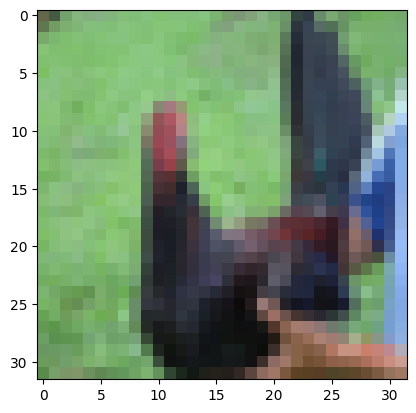

In [9]:
# TODO (5 pts)
# inference using lenet_inf created above
# note that the inference process of 1 picture using numpy may take more than 20 minutes
output = lenet_inf(image, ckpt)
label = np.argmax(output)

import matplotlib.pyplot as plt
# visualize the picture to be classified
plt.imshow(input_image)
print("Predicted label:",label)
print("Ground truth: 3")

Bonus: Calculate the number of computations and parameters. Visualize your results directly in the outputs of your codes. 

Give your answer here.  